In [1]:
# Copyright © 2018-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [2]:
%config IPCompleter.greedy=True
import matplotlib.pyplot as plt
import numpy as np
import nxsdk.api.n2a as nx
from nxsdk.utils.plotutils import plotRaster

# Synaptic plasticity
In order to demonstrate synaptic plasticity in a simple example, we study the weight dynamics of a synapse subject to an excitatory STDP learning rule. The network we configure consists of a spike generator that stimulates a learning-enabled synapse using an E-STDP learning rule. We then use another spike generator to independently drive a compartment that forms a post synaptic connection of the learning-enabled synpase. This test setup allows to control the pre and post synaptic spike times at will independently and to study the induced weight dynamics.  The network used in this tutorial is seen in the figure below.

<img src="./figures/jupyter_learning.png">

In [3]:
def setupNetwork(x1Imp, y1Imp, x1Tau, y1Tau, tEpoch):
    net = nx.NxNet()

    # Create pre and post synaptic spike generators. Both spike generators give independent control over the pre and post
    # synaptic spike trains
    spikeGenPre = net.createSpikeGenProcess(1)
    spikeGenPost = net.createSpikeGenProcess(1)

    # Create post synaptic compartment for the learning-enabled synapse. We only need the post synaptic compartment to
    # spike whenever it receives a spike from the post synaptic spike generator. Therefore, we set its threshold slightly
    # below the maximum weight and the current and voltage decay to the maximum. For the post synaptic traces to be
    # updated we need to enable the back propagation of action potential whenever the compartment spikes.
    cxp = nx.CompartmentPrototype(vThMant=250,
                                  compartmentCurrentDecay=4095,
                                  compartmentVoltageDecay=4095,
                                  enableSpikeBackprop=1,
                                  enableSpikeBackpropFromSelf=1)
    cx = net.createCompartment(cxp)

    # Connect post synaptic spike generator with the maximum weight to the compartment with a learning-disabled synapse.
    connProtoNonLrn = nx.ConnectionPrototype(weight=255,
                                             enableLearning=0)
    connNonLrn = spikeGenPost.connect(cx, prototype=connProtoNonLrn)

    # Create an E-STDP learning rule used by the learning-enabled synapse and connect the pre synaptic spike generator.
    lr = net.createLearningRule(dw='2^-2*x1*y0 - 2^-2*y1*x0',
                                x1Impulse=x1Imp,
                                x1TimeConstant=x1Tau,
                                y1Impulse=y1Imp,
                                y1TimeConstant=y1Tau,
                                tEpoch=tEpoch)
    connProtoLrn = nx.ConnectionPrototype(weight=0,
                                          enableLearning=1,
                                          learningRule=lr)
    connLrn = spikeGenPre.connect(cx, prototype=connProtoLrn)
    
    return net, spikeGenPre, spikeGenPost, cx, connNonLrn, connLrn

### Generate pre and post synaptic spikes trains

In [4]:
def genRegularSpikeTimes(numSpikes=10, spikeInterval=10):
    """Generates a regular spiking spike train."""
    
    spikeTimesBase = (np.arange(1, numSpikes) * spikeInterval)
    spikeTimes = spikeTimesBase.tolist()
    
    return spikeTimes

def genPoissonSpikeTimes(runTime, spikingProbability, tEpoch):
    """Generates an approximate Poisson spike train with a refractory period of tEpoch after each spike in order to avoid
    multiple spikes within the same learning epoch."""
    
    spikes = np.zeros((runTime, 1))
    refCtr = 0
    for i in range(runTime):
        spikes[i] = (np.random.rand(1) < spikingProbability) and refCtr <= 0
        if spikes[i]:
            refCtr = tEpoch + 1
        refCtr -= 1
    spikeTimes = np.where(spikes)[0].tolist()

    return spikeTimes

### Create probes

In [5]:
def createProbes(cx, connNonLrn, connLrn):
    probes = {}
    probes['uProbe'] = cx.probe(nx.ProbeParameter.COMPARTMENT_CURRENT)[0]
    probes['vProbe'] = cx.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0]
    probes['sProbe'] = cx.probe(nx.ProbeParameter.SPIKE)[0]
    probes['wProbeNonLrn'] = connNonLrn.probe(nx.ProbeParameter.SYNAPSE_WEIGHT)[0][0]
    probes['wProbeLrn'] = connLrn.probe(nx.ProbeParameter.SYNAPSE_WEIGHT)[0][0]
    
    return probes

### Compute the STDP weight change as a function of post and pre synaptic spike time difference

In [6]:
def extractStdpWeightChange(spikeTimesPre, spikeTimesPost, wProbeLrn):
    # Compute the weight changes for every weight change event
    w = np.array(wProbeLrn.data)
    wDiff = np.zeros(w.shape)
    wDiff[1:] = np.diff(w)

    wDiffNonZero = np.where(wDiff != 0)
    dw = wDiff[wDiffNonZero].tolist()

    # Find the absolute time of every weight change event
    time = np.array(wProbeLrn.timeVector)
    tNonZero = time[wDiffNonZero]

    # Compute the difference between post and pre synaptic spike time for every weight change event
    spikeTimesPre = np.array(spikeTimesPre)
    spikeTimesPost = np.array(spikeTimesPost)
    dt = []
    for i in range(0, len(dw)):
        timeStamp = tNonZero[i]
        tPost = (spikeTimesPost[np.where(spikeTimesPost <= timeStamp)])[-1]
        tPre = (spikeTimesPre[np.where(spikeTimesPre <= timeStamp)])[-1]
        dt.append(tPost-tPre)
        
    return dt, dw

### Plot results

In [7]:
def plotNeuronDynamics(probes):
    plt.figure(1, figsize=(18,10))
    
    plt.subplot(2, 1, 1)
    probes['uProbe'].plot()
    plt.title('COMPARTMENT_CURRENT')

    plt.subplot(2, 1, 2)
    probes['vProbe'].plot()
    plt.title('COMPARTMENT_VOLTAGE')
    plt.xlabel('Time')
    
    plt.tight_layout()
    plt.show()
    
def plotWeightChange(probes, spikeTimesPre, spikeTimesPost):
    plt.figure(2, figsize=(18,10))
    
    plt.subplot(3, 1, 1)
    probes['wProbeNonLrn'].plot()
    plt.title('WEIGHT (Learning disabled)')
    
    plt.subplot(3, 1, 2)
    sh = plotRaster([spikeTimesPre, spikeTimesPost], colors=['r', 'b'])
    plt.legend(sh, ['Pre spikes', 'Post spikes'])
    plt.title('SPIKES')
    
    plt.subplot(3, 1, 3)
    probes['wProbeLrn'].plot()
    plt.title('WEIGHT (Learning enabled)')
    plt.xlabel('Time')

    plt.tight_layout()
    plt.show()
    
def plotStdpDynamics(timeDelta, weightDeltas):
    plt.figure(3, figsize=(9,5))
    
    plt.scatter(timeDelta, weightDeltas)
    plt.title('STDP weight change')
    plt.xlabel('t_post - t_pre')
    plt.ylabel('Weight change')
        
    plt.tight_layout()
    plt.show()

### Configure and run network

In [8]:
def runNet(traceImp, traceTau, runTime, spikingProbability=0.05, tEpoch=2):
    # Setup network, generate spike times and create probes
    net, spikeGenPre, spikeGenPost, cx, connNonLrn, connLrn = setupNetwork(x1Imp=traceImp, 
                                                                           y1Imp=traceImp, 
                                                                           x1Tau=traceTau, 
                                                                           y1Tau=traceTau,
                                                                           tEpoch=tEpoch)
    spikeTimesPre = genPoissonSpikeTimes(runTime, spikingProbability, tEpoch)    
    spikeTimesPost = genPoissonSpikeTimes(runTime, spikingProbability, tEpoch)
    spikeGenPre.addSpikes(0, spikeTimesPre)
    spikeGenPost.addSpikes(0, spikeTimesPost)
    probes = createProbes(cx, connNonLrn, connLrn)    

    # Run network
    net.run(runTime)
    net.disconnect()

    # Extract weight change as a function of the difference between pre and post synaptic spike times
    actSpikeTimesPost = np.where(probes['sProbe'].data)[0]
    dt, dw = extractStdpWeightChange(spikeTimesPre, actSpikeTimesPost, probes['wProbeLrn'])
    
    return probes, dt, dw, spikeTimesPre, actSpikeTimesPost

### Run a specific network and analyze results

In [9]:
np.random.seed(0)
probes, dt, dw, spikeTimesPre, spikeTimesPost = runNet(traceImp=127, 
                                                       traceTau=10,
                                                       runTime=2000,
                                                       spikingProbability=0.025,
                                                       tEpoch=4)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:41979
INFO:DRV:      Host server up..............Done 0.21s
INFO:DRV:      Compiling Embedded snips....Done 0.17s
INFO:DRV:      Encoding axons/synapses.....Done 1.63ms
INFO:DRV:      Booting up..................Done 2.59s
INFO:DRV:      Encoding probes.............Done 0.62ms
INFO:DRV:      Configuring registers.......Done 5.77ms
INFO:DRV:      Transferring spikes.........Done 2.15ms
INFO:DRV:      Transferring probes.........Done 3.27ms
INFO:DRV:      Executing...................Done 0.14s
INFO:DRV:      Processing timeseries.......Done 0.05s
INFO:DRV:  Executor: 2000 timesteps........Done 3.20s


The compartment current integrates inputs from the learning-disabled (large positive spikes) driver synapse as well as from the learning-enabled (small spikes) synapse whose weight changes over time. Both compartment current and voltage decay instantly after receiving an input.

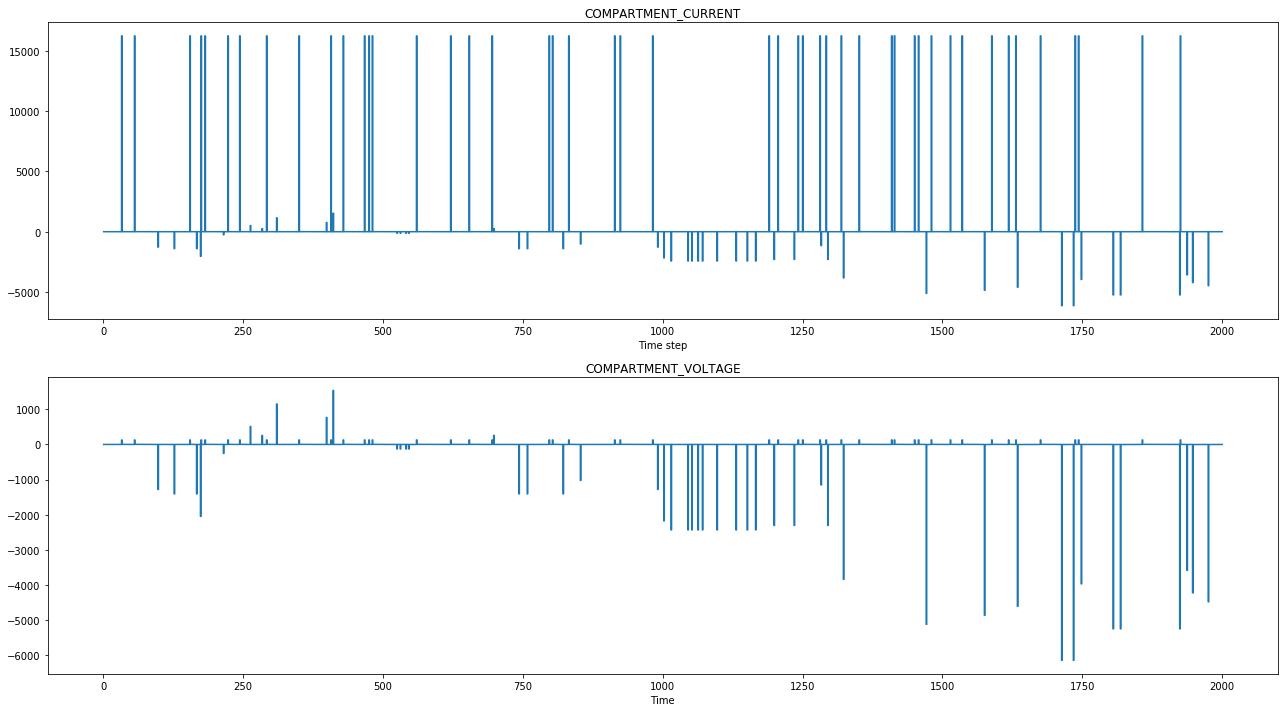

In [10]:
plotNeuronDynamics(probes)

The weight of the learning-disabled driver synapse is constant. The weight of the learning-enabled synapses fluctuates over time, as a result of temporally close pre/post or post/pre spikes.

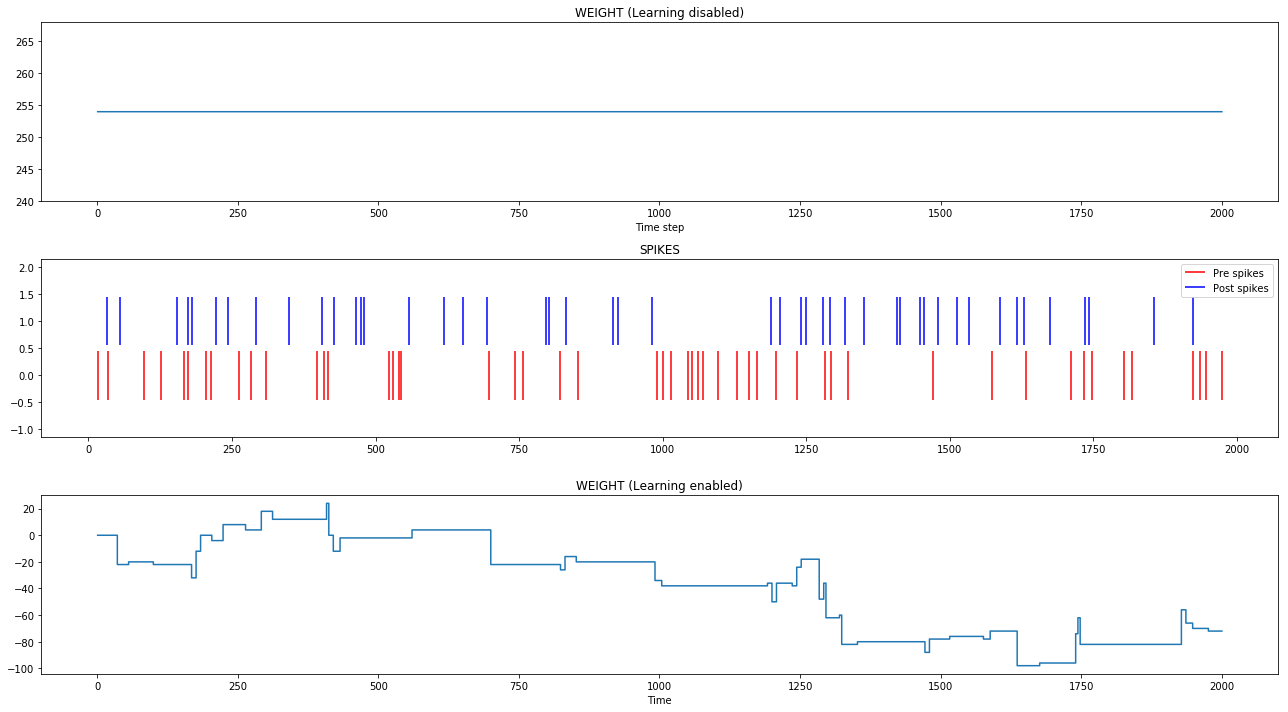

In [11]:
plotWeightChange(probes, spikeTimesPre, spikeTimesPost)

In the next figure we show the weight changes of the learning-enabled synapse as a function of the difference between post and pre synaptic spikes that preceed the weight change. The tuning curve shows the expected behavior for excitatory STDP learning: 
- Small causal spike events give rise to a large increase of the weight which decreases as the time between pre and post synaptic spike times increases.
- Small anti-causal spike events give rise to large decreases of the weight which increases as the time between post and pre synaptic spike times increases.

Note: If the weight saturates either at -256 or +255, the weight change in either direction will saturate at 0 regardless of spike time difference. Also note that if the learning epoch duration or spike frequnecy increases, the likelyhood of both pre and post synaptic spikes within an epoch increases. As a result, the induced weight change of both potentiating and depressive events can partially compensate each other which would lead to a clustering of points around the center away from the expected E-STDP behavior.

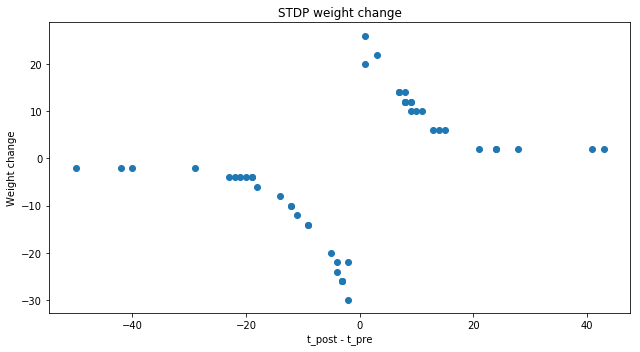

In [12]:
plotStdpDynamics(dt, dw)

.. code-links:: python clear